In [1]:
#attempting to import all the libraries and layers 
#turning MuPIPR into a jupyter script for tranining 
import tensorflow as tf
import os
from bilm import TokenBatcher, BidirectionalLanguageModel, weight_layers, \
    dump_token_embeddings

import sys
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Bidirectional  
from keras.layers import BatchNormalization, merge, add
from keras.layers.core import Flatten, Reshape
from keras.layers.merge import Concatenate, concatenate, subtract, multiply
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam,  RMSprop


import numpy as np

from tqdm import tqdm


from keras.layers import Input, CuDNNGRU, GRU
from numpy import linalg as LA
import scipy
from sklearn.model_selection import KFold, ShuffleSplit
from keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


Using TensorFlow backend.


In [2]:
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)
def contextualize(sequences):
    batcher = TokenBatcher(vocab_file)


    with tf.Session() as sess:
        # It is necessary to initialize variables once before running inference.
        sess.run(tf.global_variables_initializer())

        # Create batches of data.
        context_ids = batcher.batch_sentences(sequences)

        # Compute ELMo representations (here for the input only, for simplicity).
        elmo_context_output_ = sess.run(
            [elmo_context_output['weighted_op']],
            feed_dict={context_token_ids: context_ids}
        )
    # print(np.array(elmo_context_output_).shape)
    # print(elmo_context_output_) #contextualized embedding vector sequences
    return elmo_context_output_

## Serving contextualized embeddings of amino acids ================================

def get_session(gpu_fraction=0.25):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

def abs_diff(X):
    assert(len(X) == 2)
    s = X[0] - X[1]
    s = K.abs(s)
    return s

def abs_diff_output_shape(input_shapes):
    return input_shapes[0]

def build_model():
    seq_input1 = Input(shape=(seq_size, dim), name='seq1')
    seq_input2 = Input(shape=(seq_size, dim), name='seq2')
    seq_input3 = Input(shape=(seq_size, dim), name='seq3')
    seq_input4 = Input(shape=(seq_size, dim), name='seq4')

    l1=Conv1D(hidden_dim, 3)
    r1=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l2=Conv1D(hidden_dim, 3)
    r2=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l3=Conv1D(hidden_dim, 3)
    r3=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    # l3_end=Conv1D(hidden_dim, 3)
    
    l4=Conv1D(hidden_dim, 3)
    r4=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l5=Conv1D(hidden_dim, 3)
    r5=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l6=Conv1D(hidden_dim, 3)
    r6=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    
    l_end=Conv1D(hidden_dim, 3)
    D1=Dense(100, activation='linear')
    # D2=Dense(1, activation='sigmoid')
    D2=Dense(1, activation='linear')

    D3=Dense(100, activation='linear')
    # D2=Dense(1, activation='sigmoid')
    D4=Dense(1, activation='linear')
    
    s1=MaxPooling1D(2)(l1(seq_input1))
    s1=concatenate([r1(s1), s1])
    s1=MaxPooling1D(2)(l2(s1))
    s1=concatenate([r2(s1), s1])
    s1=MaxPooling1D(3)(l3(s1))
    s1=concatenate([r3(s1), s1])

    s1=l_end(s1)

    s1=GlobalAveragePooling1D()(s1)
    
    s2=MaxPooling1D(2)(l1(seq_input2))
    s2=concatenate([r1(s2), s2])
    s2=MaxPooling1D(2)(l2(s2))
    s2=concatenate([r2(s2), s2])
    s2=MaxPooling1D(3)(l3(s2))
    s2=concatenate([r3(s2), s2])

    s2=l_end(s2)
    s2=GlobalAveragePooling1D()(s2)
    
    subtract_abs1 = keras.layers.Lambda(abs_diff, abs_diff_output_shape)
    
    merge_text1 = multiply([s1, s2])
    merge_text2 = subtract_abs1([s1,s2])
    merge_text_12 = concatenate([merge_text2, merge_text1])
    x12 = D1(merge_text_12)
    x12 = keras.layers.LeakyReLU(alpha=0.3)(x12)
    main_output12 = D2(x12)
    
    
    s3=MaxPooling1D(2)(l1(seq_input3))
    s3=concatenate([r1(s3), s3])
    s3=MaxPooling1D(2)(l2(s3))
    s3=concatenate([r2(s3), s3])
    s3=MaxPooling1D(3)(l3(s3))
    s3=concatenate([r3(s3), s3])

    s3=l_end(s3)
    s3=GlobalAveragePooling1D()(s3)

    s4=MaxPooling1D(2)(l1(seq_input4))
    s4=concatenate([r1(s4), s4])
    s4=MaxPooling1D(2)(l2(s4))
    s4=concatenate([r2(s4), s4])
    s4=MaxPooling1D(3)(l3(s4))
    s4=concatenate([r3(s4), s4])

    s4=l_end(s4)
    s4=GlobalAveragePooling1D()(s4)
    
    subtract_abs2 = keras.layers.Lambda(abs_diff, abs_diff_output_shape)
    
    merge_text1 = multiply([s3, s4])

    # merge_text2 = merge([s1, s2], mode=lambda x: x[0] - x[1], output_shape=lambda x: x[0])
    merge_text2 = subtract_abs2([s3, s4])
    
    merge_text_34 = concatenate([merge_text2, merge_text1])

    # merge_text_34 = multiply([s3, s4])
    # x34 = Dense(100, activation='linear')(merge_text_34)
    x34 = D1(merge_text_34)

    x34 = keras.layers.LeakyReLU(alpha=0.3)(x34)
    main_output34 = D2(x34)

    merge_text_1234 = concatenate([merge_text_12, merge_text_34])
    
    x1234 = D3(merge_text_1234)
    x1234 = keras.layers.LeakyReLU(alpha=0.3)(x1234)

    main_output = D4(x1234)
    
    # merge_model = Model(inputs=[seq_input1, seq_input2, seq_input3, seq_input4], outputs=[main_output12, main_output34])
    merge_model = Model(inputs=[seq_input1, seq_input2, seq_input3, seq_input4], outputs=[main_output12, main_output34, main_output])

    return merge_model

def scale_back(v):
    # if use_log:
    #     return np.exp(v * (all_max[dim] - all_min[dim]) + all_min[dim])
    # else:
    return v * (all_max - all_min) + all_min

tf.compat.v1.keras.backend.set_session(get_session())



In [3]:
dependencies = {'pearson_r':pearson_r}
fold4Model = keras.models.load_model("fold3", custom_objects = dependencies)

In [4]:
#load MuPIPR shape Fragoza
#set up inputs


id2seq_file = '/workspace/PPI-Binding/iSee-master/processed/skempi_v1.trainAB.mut4.seq.txt'
# id2seq_file = '/workspace/PPI-Binding/BindProfX/processed/seq.txt'
# id2seq_file = '/workspace/PPI-Binding/iSee-master/processed/skempi_v1_v2.seq.txt'

# ds_file, label_index, rst_file, use_emb, hiddem_dim
ds_file = '/workspace/PPI-Binding/iSee-master/processed/4g_scores.txt'
label_index = 4
rst_file = 'results/temp.txt'
use_emb = 3
sid1_index = 0
sid2_index = 1
sid3_index = 2
sid4_index = 3
model_dim = 0
hidden_dim = 5
n_epochs = 5 

#if len(sys.argv) > 1:
ds_file, id2seq_file, label_index, rst_file, hidden_dim, n_epochs, model_dim, max_data = [
    
    "./ddgDummyFragozaML600.tab",  
    "./FragozaSequencesML600.tab",
    "4", 
    "bfx_3G_2l64_50_50_64.txt",
    "50",
    "50", 
    "64",
    "-1"
]
label_index = int(label_index)
hidden_dim = int(hidden_dim)
n_epochs = int(n_epochs)
model_dim = model_dim
max_data = int(max_data)

id2index = {}
seqs = []
index = 0
for line in open(id2seq_file):
    line = line.strip().split('\t')
    #print (line)
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1
seq_array = []
id2_aid = {}
sid = 0

# max_data = 30
limit_data = max_data > 0
raw_data = []
raw_ids = []
skip_head = False
x = None
count = 0    

#len(seqs)
#print (seqs)
#print (id2index)



In [5]:
#setup BiLM
## Serving contextualized embeddings of amino acids ================================


vocab_file='./biLM/corpus/vocab.txt'
options_file='./biLM/model/behm_'+model_dim+'skip_2l.ckpt/options.json'
weight_file='./biLM/model/behm_'+model_dim+'skip_2l.hdf5'
token_embedding_file='./biLM/model/vocab_embedding_'+model_dim+'skip_2l.hdf5'

print("Using options_file", options_file)
# options_file='../model/behm_3_2l.ckpt/options.json'
# weight_file='../model/behm_3_2l.hdf5'
# token_embedding_file='../model/vocab_embedding_dim3.hdf5'

# sequences = [['A', 'K','J','T','C','N'], ['C','A','D','A','A']]
## Now we can do inference.
# Create a TokenBatcher to map text to token ids.

# Input placeholders to the biLM.
context_token_ids = tf.placeholder('int32', shape=(None, None))

# Build the biLM graph. Adding reuse
# http://www.ifepoland.com/jiangxinyang/p/10235054.html
with tf.variable_scope("bilm", reuse=True):
    bilm = BidirectionalLanguageModel(
        options_file,
        weight_file,
        use_character_inputs=False,
        embedding_weight_file=token_embedding_file
    )

# Get ops to compute the LM embeddings.
context_embeddings_op = bilm(context_token_ids)

elmo_context_input = weight_layers('input', context_embeddings_op, l2_coef=0.0)

elmo_context_output = weight_layers(
    'output', context_embeddings_op, l2_coef=0.0
)

#set sessio 
tf.compat.v1.keras.backend.set_session(get_session())


Using options_file ./biLM/model/behm_64skip_2l.ckpt/options.json

USING SKIP CONNECTIONS
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use the `axis` argument instead




In [6]:
#set up tqdm 

for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').replace('\t\t','\t').split('\t')
    raw_ids.append((line[sid1_index], line[sid2_index], line[sid3_index], line[sid4_index]))
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]

    if id2_aid.get(line[sid3_index]) is None:
        id2_aid[line[sid3_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid3_index]]])
    line[sid3_index] = id2_aid[line[sid3_index]]

    if id2_aid.get(line[sid4_index]) is None:
        id2_aid[line[sid4_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid4_index]]])
    line[sid4_index] = id2_aid[line[sid4_index]]

    raw_data.append(line)
    
    if limit_data:
        count += 1
        if count >= max_data:
            break




1063it [00:00, 52425.10it/s]


In [7]:
#set up inputs 
len_m_seq = np.array([len(line) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
print (avg_m_seq, max_m_seq)


seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])
seq_index3 = np.array([line[sid3_index] for line in tqdm(raw_data)])
seq_index4 = np.array([line[sid4_index] for line in tqdm(raw_data)])

# print(seq_index4[:10])

print("Num of samples",len(raw_data))
print("seq_array", len(seq_array))
# print(seq_array, id2_aid)



100%|██████████| 1063/1063 [00:00<00:00, 889041.90it/s]

346 597
Num of samples 1063
seq_array 1158


In [8]:
batcher_size = 128
seq_tensor = []
max_seq_size = 749 #setting this for the test phase 
for i in range(0, len(seq_array), batcher_size):
    print(i, min(len(seq_array),i+batcher_size))
    print ("BROKE HERE A")
    # contextualize(seq_array[i:min(len(seq_array),i+batcher_size)])
    # seq_array[i:min(len(seq_array),i+batcher_size)]
    cur_tensor = contextualize(seq_array[i:min(len(seq_array),i+batcher_size)])[0]
    print ("BROKE HERE B")
    if cur_tensor.shape[1] < max_seq_size:
        # print(cur_tensor.shape[1])
        npad = ((0, 0), (0, max_seq_size - cur_tensor.shape[1]), (0, 0))
        cur_tensor = np.pad(cur_tensor, pad_width=npad, mode='constant', constant_values=0)
        # print(cur_tensor.shape)
    if seq_tensor == []:
        seq_tensor = cur_tensor
    else:
        # print(seq_tensor.shape, cur_tensor.shape)
        seq_tensor = np.concatenate((seq_tensor, cur_tensor), axis = 0)
    # seq_tensor



0 128
BROKE HERE A
BROKE HERE B
128 256
BROKE HERE A
BROKE HERE B
256 384
BROKE HERE A


/home/ubuntu/anaconda3/envs/MuPIPR_CLONE/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


BROKE HERE B
384 512
BROKE HERE A
BROKE HERE B
512 640
BROKE HERE A
BROKE HERE B
640 768
BROKE HERE A
BROKE HERE B
768 896
BROKE HERE A
BROKE HERE B
896 1024
BROKE HERE A
BROKE HERE B
1024 1152
BROKE HERE A
BROKE HERE B
1152 1158
BROKE HERE A
BROKE HERE B


In [9]:
# npad = ((0, 0), (1, 2), (2, 1))
# b = np.pad(a, pad_width=npad, mode='constant', constant_values=0)
print("seq_tensor shape",seq_tensor.shape)
seq_size, dim = seq_tensor.shape[1], seq_tensor.shape[2]
print("seq_size, dim", seq_size, dim)

num_scores = 3
score_labels = np.zeros((len(raw_data),num_scores))
# use_log = True
for i in range(len(raw_data)):
    score_labels[i] = raw_data[i][label_index:]



batch_size1 = 32
adam = Adam(lr=0.005, amsgrad=True, epsilon=1e-5)

test = np.array(list(range(0,len(score_labels))))
print (test)
print (score_labels)

seq_tensor shape (1158, 749, 128)
seq_size, dim 749 128
[   0    1    2 ... 1060 1061 1062]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [10]:
#predict on all sequences 
pred = fold4Model.predict([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]], seq_tensor[seq_index3[test]], seq_tensor[seq_index4[test]]])


In [11]:
print (pred)

[array([[0.6299283],
       [0.552089 ],
       [0.5712258],
       ...,
       [0.5776681],
       [0.4789508],
       [0.7350586]], dtype=float32), array([[0.6280548 ],
       [0.555484  ],
       [0.56794083],
       ...,
       [0.5500513 ],
       [0.48315218],
       [0.73898184]], dtype=float32), array([[0.04701877],
       [0.08121204],
       [0.03098848],
       ...,
       [0.0251036 ],
       [0.04170251],
       [0.01176956]], dtype=float32)]


In [12]:
ddG_pred = pred[2]
print (ddG_pred)

[[0.04701877]
 [0.08121204]
 [0.03098848]
 ...
 [0.0251036 ]
 [0.04170251]
 [0.01176956]]


In [13]:

#split into predictions for disruptive and non-disruptive PPI variants 
print (score_labels)
disruptions = score_labels[:,2]
unique, counts = np.unique(disruptions, return_counts=True)
counts = dict(zip(unique, counts))
print (counts)
disruptive = np.where(disruptions == 1.0)
nondisruptive = np.where(disruptions == 0.0)
print (disruptive)
disruptiveChanges = ddG_pred[disruptive]
print (disruptiveChanges)
print (nondisruptive)
nonDisruptiveChanges = ddG_pred[nondisruptive]
print (nonDisruptiveChanges)

import pandas as pd
print (disruptions.shape)
disruptions = np.reshape(disruptions, (1063,))
print (ddG_pred.shape)
ddG_pred = np.reshape(ddG_pred, (1063,))
asDF = pd.DataFrame({'Disruptive':disruptions, 'ddG':ddG_pred})
def sortDis(val):
    if val == 1.0:
        return "Disruptive Mutations \n (n=195)"
    else:
        return "Non-disruptive Mutations \n (n=868)"
    
def sortDisAddNs(val):
    if val == 1.0:
        return "Disruptive PPIs (n = 234)"
    else:
        return "Non-Disruptive PPIs (n = 1054)"
#asDF['NCount'] = asDF.apply(lambda row: sortDisAddNs(row['Disruptive']), axis = 1)
asDF['Variant PPI Effect'] = asDF.apply(lambda row: sortDis(row['Disruptive']), axis = 1)

print (asDF)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
{0.0: 868, 1.0: 195}
(array([   3,    4,    8,   14,   17,   18,   21,   27,   34,   35,   43,
         51,   52,  111,  116,  125,  126,  128,  142,  144,  147,  151,
        159,  176,  177,  184,  188,  190,  192,  193,  201,  204,  207,
        210,  216,  218,  242,  243,  261,  266,  271,  275,  280,  293,
        296,  297,  299,  321,  335,  363,  368,  388,  430,  432,  436,
        437,  438,  439,  440,  441,  442,  443,  444,  445,  446,  448,
        449,  450,  451,  452,  453,  454,  455,  456,  457,  458,  459,
        460,  461,  462,  463,  464,  465,  466,  468,  469,  470,  471,
        472,  473,  474,  481,  484,  485,  498,  514,  529,  536,  537,
        540,  542,  544,  547,  555,  557,  558,  563,  577,  593,  595,
        596,  597,  598,  599,  600,  601,  602,  618,  638,  642,  644,
        646,  669,  673,  687,  688,  690,  691,  693,  694,  695,  696,
        697,  703,  706,

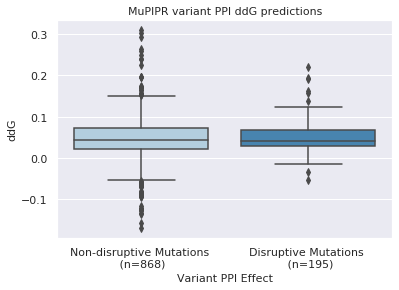

In [26]:
#try seaborn 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.font_manager._rebuild()
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"
sns.set(font="Times New Roman")
plt.figure()
b = sns.boxplot(x="Variant PPI Effect", y="ddG", data=asDF, palette="Blues")
b.axes.set_title("MuPIPR variant PPI ddG predictions",fontsize=11)
b.set_xlabel("Variant PPI Effect",fontsize=11)
b.set_ylabel("ddG",fontsize=11)
b.tick_params(labelsize=11)
plt.savefig("muPIPRResults.png", dpi = 300)

In [5]:
import random
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
from itertools import repeat
#make into a nice distribution - violin plots 
pos = [1, 2]
label = ['Disruptive PPIs (n = 195)', 'Non-Disruptive PPIs (n = 868)']
data_to_plot = [disruptiveChanges, nonDisruptiveChanges]
from itertools import repeat

red_patch = mpatches.Patch(color='red')
fake_handles = repeat(red_patch, len(pos))

plt.figure()
ax = pl.subplot(111)
pl.violinplot(data_to_plot, pos)
ax.legend(fake_handles, label)
pl.show()


NameError: name 'disruptiveChanges' is not defined